#**Detecting Fake Reviews with Self-Attention**





#*A Scaled Dot-Product Self-Attention Layer from Scratch*

The 'flexibility' to shift focus depending on the combinations of encountered tokens in an input set is what attention mechanisms seek to achieve. We are going to implement a rudimentary form of self-attention here, from scratch. It's going to provide the ability to focus on different words when generating its predictions, depending on the entire set of words that are present in the sequence. 

#*Let's Load Our Dataset as Before*

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from google.colab import files
import pandas as pd
import io
import numpy as np

# Just load the data from the Week 3 folder again.
trip_advisor = pd.read_csv('https://raw.githubusercontent.com/gburtch/BA865-2023/main/Lecture%20Materials/C/dataset/deceptive-opinion.csv')
trip_advisor = trip_advisor.sample(frac=1) # Shuffle the data since I'll eventually just use a simple validation split.

trip_advisor.describe(include='all')

# Let's convert the text to a numpy array
trip_advisor_text = trip_advisor['text'].to_numpy()

# Let's convert our string labels of fake vs. truthful reviews into 1s and 0s as labels. 
label = np.where(trip_advisor['deceptive']=='deceptive',1,0)

Let's make a TextVectorization() layer to preprocess our text into integer sequences.

In [ ]:
text_vectorization = keras.layers.TextVectorization(
    max_tokens=2000, # This means we work with 2000 most common tokens.
    output_mode="int", # This is requesting integer encodings (which means we'll have a sequence of integers)
    output_sequence_length = 784,
)

text_vectorization.adapt(trip_advisor_text)
len(text_vectorization.get_vocabulary())

2000

#*Now We Define Our Network*

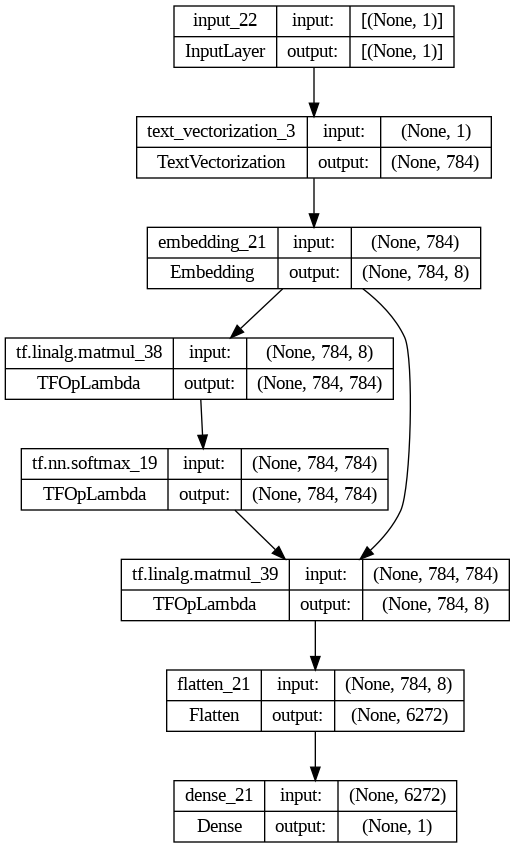

In [ ]:
def build_scaled_dotprod_model():
    inputs = keras.layers.Input(shape=(1,), dtype=tf.string) # We take a tensor of strings as input.
    integer_seqs = text_vectorization(inputs)

    # Our integer indices will be converted into 8-dimensional embeddings. 
    embeddings = layers.Embedding(2000,8)(integer_seqs)

    ### NOW LET'S BUILD THE ATTENTION MECHANISM
    
    # In Step 1, we need to compute pairwise dot-products between each word-embedding, and each other word embedding in the text sequence.
    # We have 784 word embeddings, so we should end up with 784 x 784 dot products.   
    pairwise_dot_products = tf.matmul(embeddings, embeddings, transpose_b=True)

    # In Step 2, we softmax the resulting dot products, yielding an element-wise transformation.
    # By specifying axis = -1 it means it softmaxes over the final axis of the tensor (rather than softmaxing over the entire tensor)
    # We'll end up with 784x784 scaled weights. 
    attention_weights = tf.nn.softmax(pairwise_dot_products, axis=-1)

    # Finally, in Step 3, in place of each input word embedding, we obtain the weighted sum of its peer-term attention_weights and those peer-term's input embeddings.  
    # Here, we are summing over terms (rather than over the embedding dimensions) 
    attention_output = tf.matmul(attention_weights, embeddings)

    # Flatten the attention output
    attention_output = layers.Flatten()(attention_output)

    # Output layer
    outputs = layers.Dense(1, activation='sigmoid')(attention_output)

    # Compile the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = build_scaled_dotprod_model()
keras.utils.plot_model(model,show_shapes=True)

Let's get our data ready... 

In [ ]:
data_train = trip_advisor_text[:1200]
labels_train = label[:1200]

data_test = trip_advisor_text[1200:]
labels_test = label[1200:]

And, let's try fitting this model... our custom attention layer actually does quite well. And, we actually break 90% accuracy in the validation sample this time! 

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="dotprod.tf",
                                    save_best_only=True)
]

model = build_scaled_dotprod_model()
history = model.fit(data_train, labels_train, 
                        validation_split=0.2, 
                        epochs=20, batch_size=10,callbacks=callbacks)

Epoch 1/20
96/96 [==============================] - 13s 126ms/step - loss: 0.6909 - accuracy: 0.5510 - val_loss: 0.6886 - val_accuracy: 0.4833
Epoch 2/20
96/96 [==============================] - 8s 86ms/step - loss: 0.6287 - accuracy: 0.6906 - val_loss: 0.5814 - val_accuracy: 0.8083
Epoch 3/20
96/96 [==============================] - 6s 61ms/step - loss: 0.4527 - accuracy: 0.8344 - val_loss: 0.5003 - val_accuracy: 0.7292
Epoch 4/20
96/96 [==============================] - 5s 51ms/step - loss: 0.3206 - accuracy: 0.8833 - val_loss: 0.3928 - val_accuracy: 0.8333
Epoch 5/20
96/96 [==============================] - 3s 33ms/step - loss: 0.2477 - accuracy: 0.9094 - val_loss: 0.3464 - val_accuracy: 0.8625
Epoch 6/20
96/96 [==============================] - 2s 20ms/step - loss: 0.1846 - accuracy: 0.9406 - val_loss: 0.3539 - val_accuracy: 0.8708
Epoch 7/20
96/96 [==============================] - 3s 31ms/step - loss: 0.1374 - accuracy: 0.9698 - val_loss: 0.3315 - val_accuracy: 0.8750
Epoch 8/20


And, plotting model performance, as well as evaluating against the test set, what do we get... our best model yields about 85% accuracy in the test data.

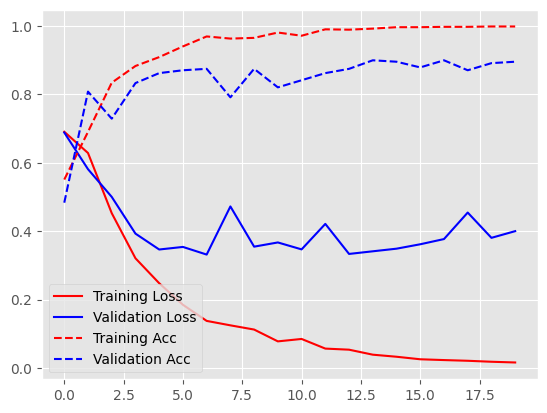

13/13 [==============================] - 0s 6ms/step - loss: 0.3631 - accuracy: 0.8475
Test acc: 0.848


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(history.history['loss'],c="r")
plt.plot(history.history['val_loss'],c="b")
plt.plot(history.history['accuracy'],c="r",linestyle="--")
plt.plot(history.history['val_accuracy'],c="b",linestyle="--")
plt.legend(['Training Loss','Validation Loss','Training Acc','Validation Acc'])
plt.show()

model = keras.models.load_model("dotprod.tf")
print(f"Test acc: {model.evaluate(data_test,labels_test)[1]:.3f}")

#*Again, Using the Multi-Head Attention Layer from Keras*

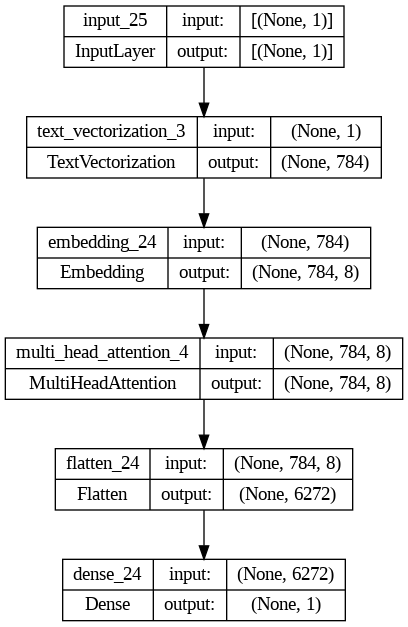

In [ ]:
def build_multi_head_attention():
    inputs = keras.layers.Input(shape=(1,), dtype=tf.string) # We take a tensor of strings as input.
    integer_seqs = text_vectorization(inputs)

    # Our integer indices will be converted into 8-dimensional embeddings. 
    embeddings = layers.Embedding(2000, 8)(integer_seqs)

    ### NOW LET'S BUILD THE MULTIHEAD SELF-ATTENTION MECHANISM
    
    # Use the built-in MultiHeadAttention layer in Keras
    num_heads = 2 # Choose the number of attention heads
    attention_layer = layers.MultiHeadAttention(num_heads=num_heads, key_dim=8) # we define the layer and mention that the keys are 8-dim embeddings.
    attention_output = attention_layer(embeddings, embeddings)

    attention_output = layers.Flatten()(attention_output)

    # Output layer
    outputs = layers.Dense(1, activation='sigmoid')(attention_output)

    # Compile the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = build_multi_head_attention()
keras.utils.plot_model(model,show_shapes=True)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("multihead.tf",
                                    save_best_only=True)
]

model_transformer = build_multi_head_attention()

history = model.fit(data_train, labels_train, 
                        validation_split=0.2, 
                        epochs=20, batch_size=10,callbacks=callbacks)

Epoch 1/20
95/96 [============================>.] - ETA: 0s - loss: 8.1335e-04 - accuracy: 1.0000

96/96 [==============================] - 14s 125ms/step - loss: 8.0499e-04 - accuracy: 1.0000 - val_loss: 0.7997 - val_accuracy: 0.8917
Epoch 2/20
93/96 [============================>.] - ETA: 0s - loss: 9.9896e-04 - accuracy: 1.0000

96/96 [==============================] - 8s 88ms/step - loss: 9.9277e-04 - accuracy: 1.0000 - val_loss: 0.7561 - val_accuracy: 0.8875
Epoch 3/20
96/96 [==============================] - 5s 51ms/step - loss: 4.6874e-04 - accuracy: 1.0000 - val_loss: 0.8644 - val_accuracy: 0.8917
Epoch 4/20
96/96 [==============================] - 4s 42ms/step - loss: 4.2409e-04 - accuracy: 1.0000 - val_loss: 0.7971 - val_accuracy: 0.8833
Epoch 5/20
96/96 [==============================] - 3s 30ms/step - loss: 3.6438e-04 - accuracy: 1.0000 - val_loss: 0.8375 - val_accuracy: 0.8917
Epoch 6/20
96/96 [==============================] - 3s 33ms/step - loss: 2.7635e-04 - accuracy: 1.0000 - val_loss: 0.8154 - val_accuracy: 0.8833
Epoch 7/20
96/96 [==============================] - 3s 28ms/step - loss: 2.3404e-04 - accuracy: 1.0000 - val_loss: 0.8282 - val_accuracy: 0.8833
Epoch 8/20
96/96 [==============================] - 2s 23ms/step - loss: 2.2057e-04 - accuracy: 1.0000 - val_loss: 0.8470 - val_accuracy: 0.8

And plotting loss over training, and checking loss against test set... this model is also pretty good - it performs similarly, getting us to about 86% accuracy. This model also gets there after 1 epoch!

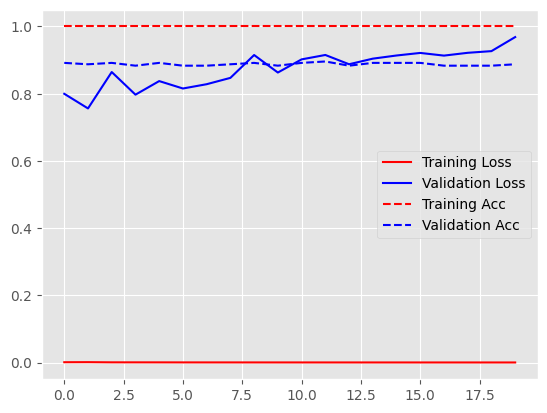

13/13 [==============================] - 0s 11ms/step - loss: 0.8429 - accuracy: 0.8625
Test acc: 0.863


In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(history.history['loss'],c="r")
plt.plot(history.history['val_loss'],c="b")
plt.plot(history.history['accuracy'],c="r",linestyle="--")
plt.plot(history.history['val_accuracy'],c="b",linestyle="--")
plt.legend(['Training Loss','Validation Loss','Training Acc','Validation Acc'])
plt.show()

model = build_multi_head_attention()
model.load_weights("multihead.tf")
print(f"Test acc: {model.evaluate(data_test,labels_test)[1]:.3f}")